In [ ]:
!pip install "sb3_contrib>=2.0.0a1" --upgrade
!pip install "stable_baselines3>=2.0.0a1" --upgrade
!pip install pvlib

## Download the folder "BEAR" and upload it to your Drive in "My Drive", then run the cells

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
import os
cwd = os.getcwd()
os.chdir("gdrive/My Drive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
from BEAR.Env.env_building  import BuildingEnvReal
from BEAR.Controller.MPC_Controller import MPCAgent,MPCAgent_DataDriven
from BEAR.Utils.utils_building import ParameterGenerator,get_user_input
import numpy as np
import functools
import datetime
import os
import time
from collections import deque
import matplotlib.pyplot as plt

**In this example, we use a customized model outside of the GEAR given models. The following building is selected from the EnergyPlus example files. We try to develop it in our building model generator and compare the simulation results.**

We start by creating an environment:

In [4]:
numofhours=24*(4)
chicago=[20.4,20.4,20.4,20.4,21.5,22.7,22.9,23,23,21.9,20.7,20.5]
city='chicago'
filename='Exercise2A-mytestTable.html'
weatherfile='USA_IL_Chicago-OHare.Intl.AP.725300_TMY3.epw'
U_Wall=[2.811,12.894,0.408,0.282,1.533,12.894,1.493]
U_Wall=[value * 1 for value in U_Wall]
Parameter=ParameterGenerator(filename,weatherfile,city,U_Wall=U_Wall,Ground_Tp=chicago,shgc=0.568,AC_map=np.array([1,1,1,1,1,0])
                            ,shgc_weight=0.1,ground_weight=0.7,full_occ=np.array([1,2,3,4,5,0]),
                            reward_gamma=[0.01,0.99],activity_sch=np.ones(100000000)*1*117.24,max_power=np.array([4100,2100,4100,2100,4100,4100])) #Description of ParameterGenerator in bldg_utils.py
env = BuildingEnvReal(Parameter)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


###############All Zones from Ground############
SOUTH PERIMETER  [Zone index]:  0
EAST PERIMETER  [Zone index]:  1
NORTH PERIMETER  [Zone index]:  2
WEST PERIMETER  [Zone index]:  3
CORE  [Zone index]:  4
PLENUM  [Zone index]:  5
###################################################


In [5]:
obs_dim = env.observation_space.shape[0]
print("Size of State Space ->  {}".format(obs_dim))
action_dim = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(action_dim))
upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]
print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))

Size of State Space ->  10
Size of Action Space ->  6
Max Value of Action ->  1.0
Min Value of Action ->  -1.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We use a MPC controller to set the indoor temperature at $22^\circ$C with a daily operating schedule of 8 a.m. to 3 p.m.

In [7]:
agent = MPCAgent(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset()
schedule=np.concatenate([np.ones(6)*0,np.ones(7)*1,np.ones(11)*0])
for i in range(numofhours):
    a,s = agent.predict(env)
    if schedule[i%24]==0:
      a=a*0
    # print('lala',np.sum(a)*400)
    obs, r, terminated, truncated, _= env.step(a)

MPCstate=env.statelist
MPCaction=env.actionlist

For comparison, we also get Energyplus state and action under the same control logic:

In [8]:
import pandas as pd
numofhours=24*90
all=pd.read_csv('BEAR/Data/Exercise2A-mytest.csv')
# all=pd.read_csv('Exercise2A-all22.csv')
# all=pd.read_csv('Exercise2A-1822.csv')
pltemp=all['PLENUM:Zone Air Temperature [C](Hourly)']
plheat=all['PLENUM:Zone Air System Sensible Heating Rate [W](Hourly)']
southheat = all['SOUTH PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
southcool=all['SOUTH PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
southtemp=all['SOUTH PERIMETER:Zone Air Temperature [C](Hourly)']
eastheat = all['EAST PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
eastcool=all['EAST PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
easttemp=all['EAST PERIMETER:Zone Air Temperature [C](Hourly)']
northheat = all['NORTH PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
northcool=all['NORTH PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
northtemp=all['NORTH PERIMETER:Zone Air Temperature [C](Hourly)']
westheat = all['WEST PERIMETER:Zone Air System Sensible Heating Rate [W](Hourly)']
westcool=all['WEST PERIMETER:Zone Air System Sensible Cooling Rate [W](Hourly)']
westtemp=all['WEST PERIMETER:Zone Air Temperature [C](Hourly)']
coreheat = all['CORE:Zone Air System Sensible Heating Rate [W](Hourly)']
corecool=all['CORE:Zone Air System Sensible Cooling Rate [W](Hourly)']
coretemp=all['CORE:Zone Air Temperature [C](Hourly)']
whole=all['Whole Building:Facility Total HVAC Electricity Demand Rate [W](Hourly)']
outtemp=all['Environment:Site Outdoor Air Drybulb Temperature [C](Hourly)']

EP_totalpower=southheat[:numofhours]+eastheat[:numofhours]+northheat[:numofhours]+westheat[:numofhours]+coreheat[:numofhours]+southcool[:numofhours]+eastcool[:numofhours]+northcool[:numofhours]+westcool[:numofhours]+corecool[:numofhours]
EP_state=[southtemp[:numofhours],easttemp[:numofhours],northtemp[:numofhours],westtemp[:numofhours],coretemp[:numofhours],pltemp[:numofhours]]
EP_power=[southheat[1:numofhours+1]-southcool[1:numofhours+1],eastheat[1:numofhours+1]-eastcool[1:numofhours+1],northheat[1:numofhours+1]-northcool[1:numofhours+1],westheat[1:numofhours+1]-westcool[1:numofhours+1],coreheat[1:numofhours+1]-corecool[1:numofhours+1],plheat[1:numofhours+1]]


Then we train a data-driven model with linear regression under same condition with the simulated data of Energyplus state and action

In [12]:
options={'T_initial':np.array([18.24489859, 18.58710076, 18.47719682, 19.11476084, 19.59438163,
        15.39221207])}
env.reset(options=options)
env.train(np.array(EP_state).T,np.array(EP_power).T)
agent = MPCAgent_DataDriven(env,
                gamma=env.gamma,
                safety_margin=0.96, planning_steps=10)
env.reset(options=options)
for i in range(24*4):

    a,s = agent.predict(env)
    if schedule[i%24]==0:
      a=a*0
    obs, r, terminated, truncated, _= env.step(a)



NMPCstate=env.statelist
NMPCaction=env.actionlist

<>:18: DeprecationWarning: invalid escape sequence '\c'


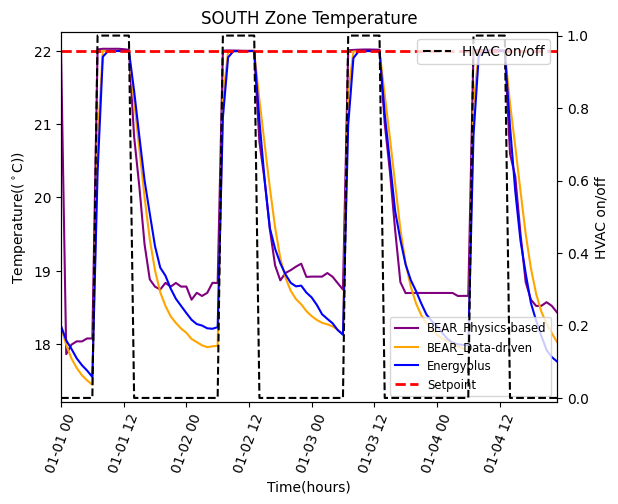

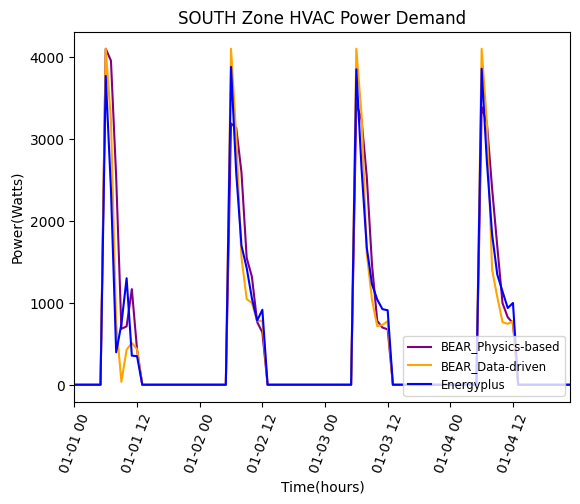

In [13]:
dates = [datetime.datetime(2018, 1, 1) + datetime.timedelta(hours=k * 1)
        for k in range(24*4)]
fig, ax1 = plt.subplots()
numofhours=24*4
#################  PLOT A###################################

# DD_state=modelfit.predict(np.array(current_state))[:24*4-1]
# DD_state=np.insert(DD_state,0,np.array([18.24489859, 18.58710076, 18.47719682, 19.11476084, 19.59438163,15.39221207]),axis=0)
ax1.plot(dates,np.array(MPCstate)[:numofhours,0],color = 'purple')
# ax1.plot(dates,DD_state[:,0],color = 'orange')
ax1.plot(dates,np.array(NMPCstate)[:numofhours,0],color = 'orange')
ax1.plot(dates,EP_state[0][:numofhours],color = 'blue')


ax1.hlines(y=22, xmin=dates[0], xmax=dates[-1], colors='red', linestyles='--', lw=2, label='Multiple Lines')
ax1.set_title('SOUTH Zone Temperature')
ax1.set_xlabel('Time(hours)')
ax1.set_ylabel('Temperature(($^\circ$C))')
ax1.legend(['BEAR_Physics-based','BEAR_Data-driven','Energyplus','Setpoint'],loc='lower right',fontsize='small')
ax1.set_xlim([dates[0], dates[-1]])
plt.xticks(rotation=70)
data2=np.concatenate([np.ones(1)*0,schedule,schedule,schedule,schedule])[:-1]
ax2 = ax1.twinx()
ax2.plot(dates, data2,'--', color = 'black')
ax2.set_ylim([-0.01, 1.01])
ax2.legend(['HVAC on/off'])
plt.ylabel('HVAC on/off')
plt.show()
################################################################

# EP_totalpower=whole[:numofhours]
# MPC_totalpower=np.sum(np.abs(np.array(MPCaction)),1)
MPC_totalpower=np.array(MPCaction)
####################   PLOT B #############################
plt.plot(dates,np.abs(MPC_totalpower[:,0]),color = 'purple')
plt.plot(dates,np.abs(np.array(NMPCaction)[:,0]),color = 'orange')
plt.plot(dates,np.abs(np.array(EP_power)[0,:24*4]),color = 'blue')

# plt.plot(dates,np.array(EP_power)[1,:24*4],color = 'orange')
plt.xticks(rotation=70)
plt.title('SOUTH Zone HVAC Power Demand')
plt.xlabel('Time(hours)')
plt.ylabel('Power(Watts)')
plt.legend(['BEAR_Physics-based','BEAR_Data-driven','Energyplus'],loc='lower right',fontsize='small')
plt.xlim([dates[0], dates[-1]])
plt.show()

In [14]:
env.close()